In [1]:
import pandas as pd
import seaborn as sns
%matplotlib inline

---
# Load genomes metadata

In [2]:
genomes_df = pd.read_csv("../data/Table_S2. Cyanophages collection.tsv", sep="\t")

In [3]:
genomes_df.head()

,Name,Accession,Tax,Host,Comment,NCBI,mash
0,9515-10a,NC_016657,Podoviridae,Pro,NaN,1,1
1,ACG-2014b,NC_027130,Myoviridae,Syn,NaN,1,1
2,ACG-2014c_C97,KJ019063,Myoviridae,Syn,NaN,1,1
3,ACG-2014d,NC_026923,Myoviridae,Syn,NaN,1,1
4,ACG-2014e,NC_026928,Myoviridae,Syn,NaN,1,1


In [4]:
genomes_df.loc[((genomes_df["mash"]==1) & (genomes_df["NCBI"]==1)), ["Name", "Accession"]].to_csv("../data/ncbi_phages_2018_02_28.tsv", sep="\t", index=False, header=False)

In [5]:
!mkdir -p ../data/fasta/ncbi

In [ ]:
!rm ../data/fasta/ncbi/*.fasta

Synechococcus and Prochlorococcus genomes where downloaded from the NCBI using parallel and the following one liner:

```
time parallel --colsep '\t' 'url="https://www.ncbi.nlm.nih.gov/sviewer/viewer.cgi?tool=portal&save=file&log$=seqview&db=nuccore&report=fasta&id={2}&extrafeat=976&conwithfeat=on&withparts=on"; echo ">"{1} > ../data/fasta/ncbi/{1}.fasta; curl $url | grep -v ">" >> ./data/fasta/ncbi/{1}.fasta' :::: "../data/ncbi_phages_2018_02_28.tsv"
```

The genomes from the NCBI and the MAGs were concatenated into '../data/fasta/phages.fasta'

`cat ../data/fasta/ncbi/*.fasta ../data/fasta/mags/*.fasta > ../data/fasta/phages.fasta`


In [ ]:
%%bash
time parallel --colsep '\t' 'url="https://www.ncbi.nlm.nih.gov/sviewer/viewer.cgi?tool=portal&save=file&log$=seqview&db=nuccore&report=fasta&id={2}&extrafeat=976&conwithfeat=on&withparts=on"; echo ">"{1} > ../data/fasta/ncbi/{1}.fasta; curl -s $url | grep -v ">" >> ../data/fasta/ncbi/{1}.fasta' :::: "../data/ncbi_phages_2018_02_28.tsv"

In [ ]:
%%bash
cat ../data/fasta/mags/bac_mags.fasta ../data/fasta/ncbi/*.fasta > ../data/fasta/phages.fasta

---
# Calculate mash distances and load them

In [ ]:
%%bash
mkdir -p ../data/mash
i=7500
ifile=../data/fasta/phages.fasta
bn=$(basename $ifile .fasta)
#path to the mash sketch file
mash_msh=../data/mash/${bn}_${i}.msh
#generate the mash sketch
mash sketch -p 4 -i -s ${i} -o ${mash_msh} ${ifile}
#measure the mash distance
mash dist -p 4 -t ${mash_msh} ${mash_msh} > ${mash_msh/.msh/.tsv}
# gather the size of each genome from the mash sketch
#mash info ${mash_msh} | tail -n+10 | sed '/^$/d' | tr -s ' ' | tr ' ' '\t' | cut -f3,4 > ../data/phages_sizes.txt

In [6]:
df_7500 = pd.read_csv("../data/mash/phages_7500.tsv", sep="\t", index_col=0)

In [7]:
df = df_7500

----
# Prepare figure

## Build dataframe with row colors

In [8]:
lut = dict(zip(['?', 'Podoviridae', 'Myoviridae', 'Siphoviridae', 'Myoviridae_D'], ['#e41a1c','#377eb8','#984ea3','#4daf4a', '#111111']))

In [9]:
lut_host = dict(zip(['?', 'Pro', 'Syn'], ['red','gray','brown']))

In [10]:
col_colors = pd.concat([genomes_df["Name"], genomes_df["Tax"].map(lut), genomes_df["Host"].map(lut_host)], axis=1)

In [11]:
col_colors.rename(columns={"Name":"#query"}, inplace=True)

In [12]:
col_colors.set_index("#query", inplace=True)

## Draw clustermaps

In [13]:
mags_syn_genomes = genomes_df.loc[genomes_df["Host"].isin(["Syn", "?"]), "Name"]

In [14]:
mags_pro_genomes = genomes_df.loc[genomes_df["Host"].isin(["Pro", "?"]), "Name"]

/Users/jfloresu/.virtualenvs/jupyter/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/Users/jfloresu/.virtualenvs/jupyter/lib/python3.6/site-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0
  'bottom=%s, top=%s') % (bottom, top))


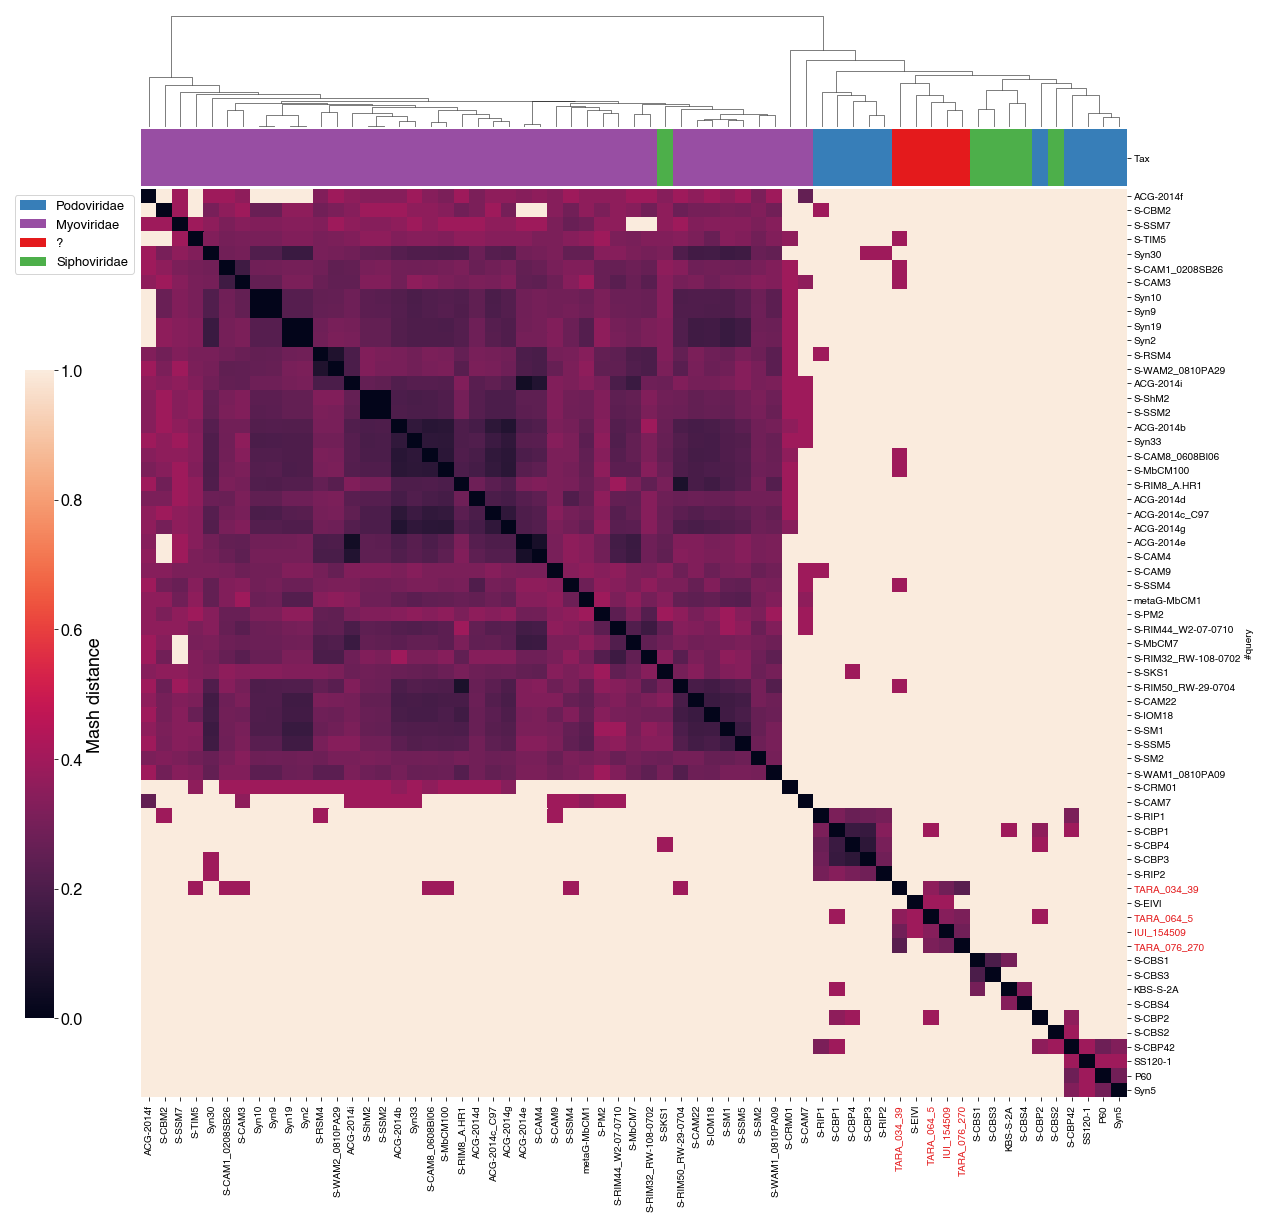

In [15]:
g = sns.clustermap(df.loc[mags_syn_genomes, mags_syn_genomes], figsize=(20,20), metric="euclidean", col_colors=col_colors["Tax"])

g.ax_col_dendrogram.bar(1,100,1,50, color='red')

# Create legend for dendrogram
for label in genomes_df["Tax"].unique():
    g.ax_row_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=0)

g.ax_row_dendrogram.legend(loc='upper center', ncol=1, fontsize=13);
g.ax_row_dendrogram.set_ylim([0,0]); # Hide right dendrogram but keep legend



#set the position of the colorbar[x,]
g.ax_heatmap.collections[0].colorbar.set_label("Mash distance", size=18)
g.ax_heatmap.collections[0].colorbar.ax.tick_params(labelsize=16) 
g.cax.set_position([.135,.18,.02,.45])

#color the labels of MAGs
mags = genomes_df.loc[genomes_df["NCBI"]==0, "Accession"].values
for tick_label in g.ax_heatmap.axes.get_yticklabels():
    if tick_label.get_text() in mags:
        tick_label.set_color(lut["?"])
for tick_label in g.ax_heatmap.axes.get_xticklabels():
    if tick_label.get_text() in mags:
        tick_label.set_color(lut["?"])

/Users/jfloresu/.virtualenvs/jupyter/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/Users/jfloresu/.virtualenvs/jupyter/lib/python3.6/site-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0
  'bottom=%s, top=%s') % (bottom, top))


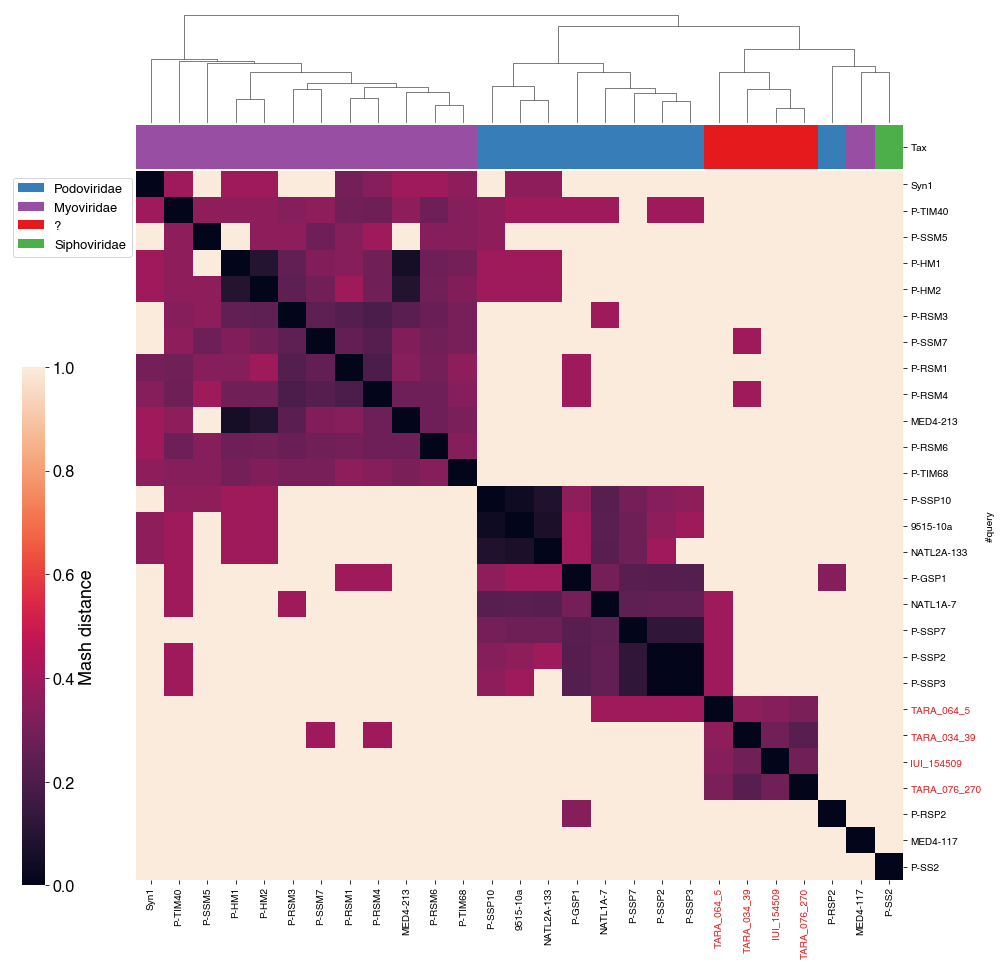

In [16]:
g = sns.clustermap(df.loc[mags_pro_genomes, mags_pro_genomes], figsize=(16,16), metric="euclidean", col_colors=col_colors["Tax"])

# Create legend for dendrogram
for label in genomes_df["Tax"].unique():
    g.ax_row_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=0)

g.ax_row_dendrogram.legend(loc='upper center', ncol=1, fontsize=13);
g.ax_row_dendrogram.set_ylim([0,0]); # Hide right dendrogram but keep legend

#set the position of the colorbar[x,]
g.ax_heatmap.collections[0].colorbar.set_label("Mash distance", size=18)
g.ax_heatmap.collections[0].colorbar.ax.tick_params(labelsize=16) 
g.cax.set_position([.135,.12,.02,.45])

#color the labels of MAGs
mags = genomes_df.loc[genomes_df["NCBI"]==0, "Accession"].values
for tick_label in g.ax_heatmap.axes.get_yticklabels():
    if tick_label.get_text() in mags:
        tick_label.set_color(lut["?"])
for tick_label in g.ax_heatmap.axes.get_xticklabels():
    if tick_label.get_text() in mags:
        tick_label.set_color(lut["?"])

Genomic clustering of Synechococcus phages genomes using Mash. Heat map illustrate the pairwise similarity between genomes, scaled between 0 (black) and 1 (white). Genome groups are identified and colored according to the taxonomy obtained from the NCBI, Myoviridae (Purple), Podoviridae (Blue), Siphoviridae(green), and Unclassified (red.) The Mash clustering identifies one big cluster of phages belonging to the Myoviridae genomes as well as small clusters belonging to Podoviridae and Siphoviridae.

In [22]:
#g.savefig("./clustermap.pdf")

```
#g.savefig("./clustermap.pdf")
from PIL import Image
from io import BytesIO
# save figure
# (1) save the image in memory in PNG format
png1 = BytesIO()
g.savefig(png1, format='png', dpi=300)

# (2) load this image into PIL
png2 = Image.open(png1)

# (3) save as TIFF
png2.save('clustermap_300dpi.tiff')
png1.close()
png2.close()
```

---